# Example: building segmentation
## Use the Looking Glass docker image to run inference on satellite images

This example shows how to run inference (i.e., prediction) with the Looking Glass model to obtain building segmentation masks. The ML model is packaged up within a Docker container on DockerHub (`developmentseed/looking-glass`). We'll show how to go from image to building mask in the following steps:
1. obtain and run the Looking Glass container
1. package images for inference as b64 strings
1. send inference request
1. process and plot inference responses

### See notes at the end for 
1. downloading/processing satellite image tiles
2. Pointers to get started with a GPU image

### Run the below in your terminal to start the Looking Glass container:
You shouldn't need to, but if you need to rebuild the TF Serving image, that process is shown at the bottom of `export_keras_ex.py`. This uses the CPU version, but it's also possible to run the model on a GPU for faster performance. See notes at end.

`docker run -p 8501:8501 -t developmentseed/looking-glass:v2`

In [1]:
import os
import os.path as op
import base64
import json

import requests
import numpy as np
import imageio
from matplotlib import pyplot as plt

# Looking Glass expects 256x256 RGB images at zoom 18
IMG_HEIGHT, IMG_WIDTH = 256, 256

## Build a prediction request as a json payload

In [2]:
img_fnames = ['RGB-PanSharpen_AOI_3_Paris_img100_crop_9.png']
img_fpaths = [op.join(os.getcwd(), 'test', img_fname) for img_fname in img_fnames]

# Build json payload
instances = []
for img_fpath in img_fpaths:
    with open(img_fpath, 'rb') as imageFile:
        # We convert to b64 because it significantly reduces the size of our payload
        b64_image = base64.b64encode(imageFile.read())
        b64_str = b64_image.decode('utf-8')
        instances.append({'image_bytes': {'b64': b64_str}})

payload = json.dumps({"instances": instances})
print(f'Built an inference request for {len(instances)} local image(s).')


Built an inference request for 1 local image(s).


## Send images to Docker container for prediction

In [3]:
# This defines the ML model's inference endpoint
server_endpoint = 'http://localhost:8501/v1/models/looking_glass:predict'

print('Num of images in payload: {}'.format(len(instances)))
%time r = requests.post(server_endpoint, data=payload)

Num of images in payload: 1
CPU times: user 11.2 ms, sys: 4.7 ms, total: 15.9 ms
Wall time: 2.85 s


## Convert predictions to numpy array

In [4]:
pred_raw = json.loads(r.content)['predictions']
n_pred =len(pred_raw)

print(f'\nReceived {n_pred} prediction(s).')
pred_arr = np.asarray(pred_raw).reshape(n_pred, IMG_HEIGHT, IMG_WIDTH)

print(f'Prediction array shape: {pred_arr.shape}')


Received 1 prediction(s).
Prediction array shape: (1, 256, 256)


## Plot prediction results

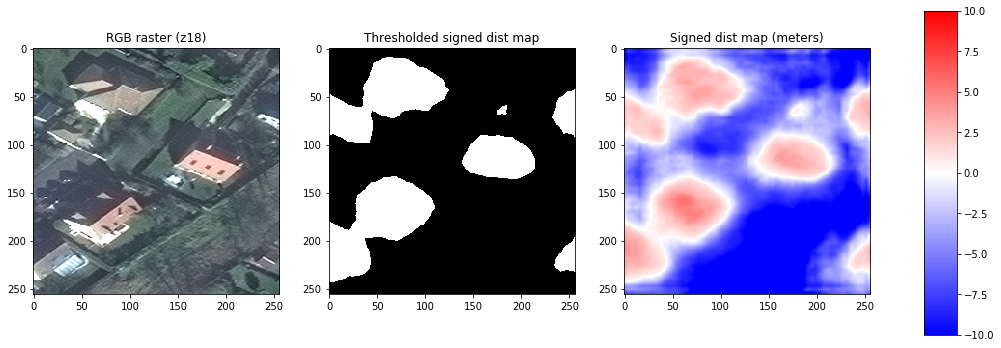

In [5]:
# Select the image index to plot
img_index = 0
orig_img = imageio.imread(img_fpaths[img_index])

fig, axes = plt.subplots(1, 3, figsize=(15, 9))

# Plot each array
axes[0].imshow(orig_img)
axes[1].imshow(pred_arr[img_index] >= 0, cmap=plt.get_cmap('gray'))
sd_im = axes[2].imshow(pred_arr[img_index], cmap=plt.get_cmap('bwr'), vmin=-10, vmax=10)

# Add sidebar and titles
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
fig.colorbar(sd_im, cax=cbar_ax)

titles = ['RGB raster (z18)', 'Thresholded signed dist map', 'Signed dist map (meters)']
for ax, title in zip(axes, titles):
    ax.set_title(title)

## Kill docker container

`docker container stop <container-id/name>`

`docker container rm <container-id/name>`

## Helper function for downloading sateliite images

In [6]:
# We didn't download any satellite imagery in this example, but this function is helpful if you do
def url_image_to_b64_string(url):
    """Convert a url to a UTF-8 coded string of base64 bytes.
    Notes
    -----
    Use this if you need to download tiles from a tile server and send them to
    a prediction server. This will convert them into a string representing
    base64 format which is more efficient than many other options.
    """
    # GET data from url
    response = requests.get(url)
    if not response.ok:
        print('Error getting image from {}'.format(url))

    # Convert to base64 and then encode in UTF-8 for future transmission
    b64 = base64.b64encode(response.content)
    b64_string = b64.decode("utf-8")

    return b64_string

### Using a GPU Docker image

To run the GPU version, see tensorflow's website for requirements:
https://www.tensorflow.org/serving/docker#serving_with_docker_using_your_gpu

You should be able to run the GPU image with something like:

`docker run --runtime=nvidia -p 8501:8501 -t developmentseed/looking-glass:<container_tag w/ '-gpu'>`